In [614]:

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import importlib 
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import os 
import time
from pathlib import Path
if sys.version_info < (3, 0):
    import ConfigParser
else:
    import configparser as ConfigParser
    
import pyzelda.zelda as zelda
import pyzelda.ztools as ztools
import pyzelda.utils.aperture as aperture

# path to the folder that contains your module/package
module_dir = Path('/Users/bencb/Documents/ASGARD/BaldrApp/')  # e.g. Path.home() / "projects/my_pkg/src"
sys.path.insert(0, str(module_dir))  

from baldrapp.common import baldr_core as bldr
from baldrapp.common import DM_basis
from baldrapp.common import utilities as util
from baldrapp.common import phasescreens as ps

import aotools

def upsample_by_factor(ar: np.ndarray, f: int | tuple[int, int]) -> np.ndarray:
    """
    Upsample 2D array by integer factor(s) via block replication (nearest-neighbour).
    If f is an int, uses the same factor on both axes. If f=(fy, fx), uses per-axis factors.
    """
    ar = np.asarray(ar)
    if ar.ndim != 2:
        raise ValueError("ar must be 2D")
    fy, fx = (f, f) if isinstance(f, int) else f
    if fy < 1 or fx < 1:
        raise ValueError("factors must be positive integers")
    return np.repeat(np.repeat(ar, fy, axis=0), fx, axis=1)


def pad_to_shape_edge(arr: np.ndarray, target_shape: tuple[int, int]) -> np.ndarray:
    """
    Grow a 2D array to target_shape by copying its edges (last row/col).
    Equivalent to np.pad(..., mode='edge').
    """
    if arr.ndim != 2:
        raise ValueError("arr must be 2D")
    m, n = arr.shape
    M, N = target_shape
    if M < m or N < n:
        raise ValueError("target_shape must be >= current shape in both dims")

    pad_rows = M - m
    pad_cols = N - n
    return np.pad(arr, ((0, pad_rows), (0, pad_cols)), mode="edge")


def upsample( ar, target_size ):
    out_almost = upsample_by_factor(ar, target_size//len(ar) ) # 
    if np.mod( target_size, len(ar) ) != 0: # not even divisor, we just pad! 
        out = pad_to_shape_edge( out_almost , target_shape = (target_size,target_size))
    else :
        out = out_almost
    return( out )


def update_scintillation( high_alt_phasescreen , pxl_scale, wavelength, final_size = None,jumps = 1,propagation_distance=10000):
    for _ in range(jumps):
        high_alt_phasescreen.add_row()
    wavefront = np.exp(1J *  high_alt_phasescreen.scrn ) # amplitude mean ~ 1 
    propagated_screen = aotools.opticalpropagation.angularSpectrum(inputComplexAmp=wavefront,
                                                               z=propagation_distance, 
                                                               wvl=wavelength, 
                                                               inputSpacing = pxl_scale, 
                                                               outputSpacing = pxl_scale
                                                               )
    print("upsample it scintillation screen")
    if final_size is not None:
        amp = upsample(propagated_screen, final_size ) # This oversamples to nearest multiple size, and then pads the rest with repeated rows, not the most accurate but fastest. Negligible if +1 from even number
    else:
        amp = propagated_screen

    return( abs(amp) ) # amplitude of field, not intensity (amp^2)! rotate 90 degrees so not correlated with phase 




### Set up manually 

grid_dict = {
    "telescope":"DISC", #'AT',
    "D":1.8, # diameter of beam 
    "N" : 64, # number of pixels across pupil diameter
    "dim": 64 * 4 #4 
    #"padding_factor" : 4, # how many pupil diameters fit into grid x axis
    # TOTAL NUMBER OF PIXELS = padding_factor * N 
    }

# I should include coldstop here!! 
optics_dict = {
    "wvl0" :1.65e-6, # central wavelength (m) 
    "F_number": 21.2, # F number on phasemask
    "mask_diam": 1.06, # diameter of phaseshifting region in diffraction limit units (physical unit is mask_diam * 1.22 * F_number * lambda)
    "theta": 1.57079, # phaseshift of phasemask 
    ### NEw have not consistenty propagate this in functions in baldr_core
    "coldstop_diam": 4, #1.22 lambda/D units
    "coldstop_offset":(1,0)
}

dm_dict = {
    "dm_model":"BMC-multi-3.5",
    "actuator_coupling_factor":0.7,# std of in actuator spacing of gaussian IF applied to each actuator. (e.g actuator_coupling_factor = 1 implies std of poke is 1 actuator across.)
    "dm_pitch":1,
    "dm_aoi":0, # angle of incidence of light on DM 
    "opd_per_cmd" : 3e-6, # peak opd applied at center of actuator per command unit (normalized between 0-1) 
    "flat_rmse" : 20e-9 # std (m) of flatness across Flat DM  
    }

grid_ns = SimpleNamespace(**grid_dict)
optics_ns = SimpleNamespace(**optics_dict)
dm_ns = SimpleNamespace(**dm_dict)

zwfs_ns = bldr.init_zwfs(grid_ns, optics_ns, dm_ns)


In [ ]:
## Check phase mask and coldstop dimensions relative to PSF in image plane 

## Check phase mask and coldstop dimensions relative to PSF in image plane

get_pupil_intensity is the underlying function that we use in get_frame() method if use_pyZelda is False 

we changed get_pupil_intensity to use fft rather than mft because its like 10 times faster (even if we have to reinit phase mask and cold stop masks each iteration!!)! Previously we made pre-computed phase mask and image plane sampling based on set sampling of the PSF : 
    zwfs_ns.grid.phasemask_mask
    zwfs_ns.focal_plane. 
with the new fft this is somewhat redundant since sampling depends on user input and cannot as simply invocate set grids without cropping/padding etc.  We still have fplane_pixels, and 

Therefore the new get_pupil_intensity has some redundant inputs (signatures in the function) including : 
     pupil_diameter, pixels_across_mask=

we keep them for now for legacy 


Also the new addition doesnt normalize flux 

0.1278519630432129


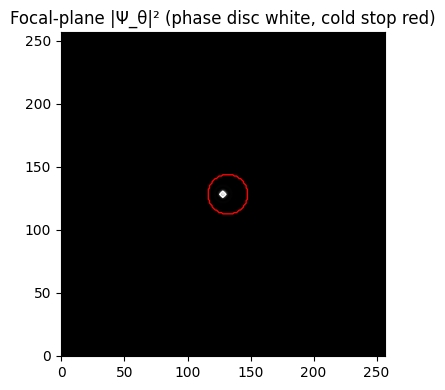

0.027933835983276367


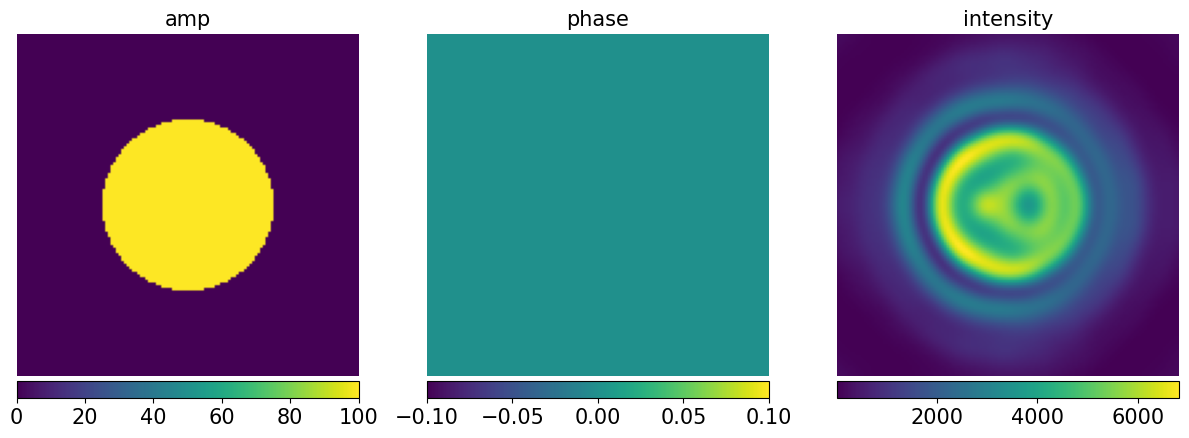

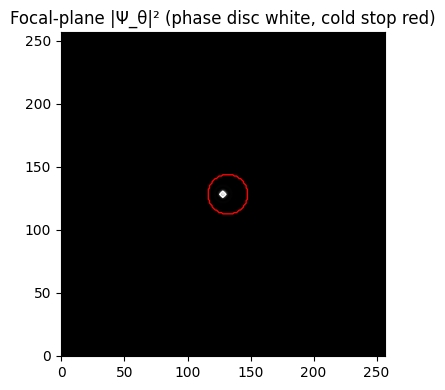

0.05108189582824707


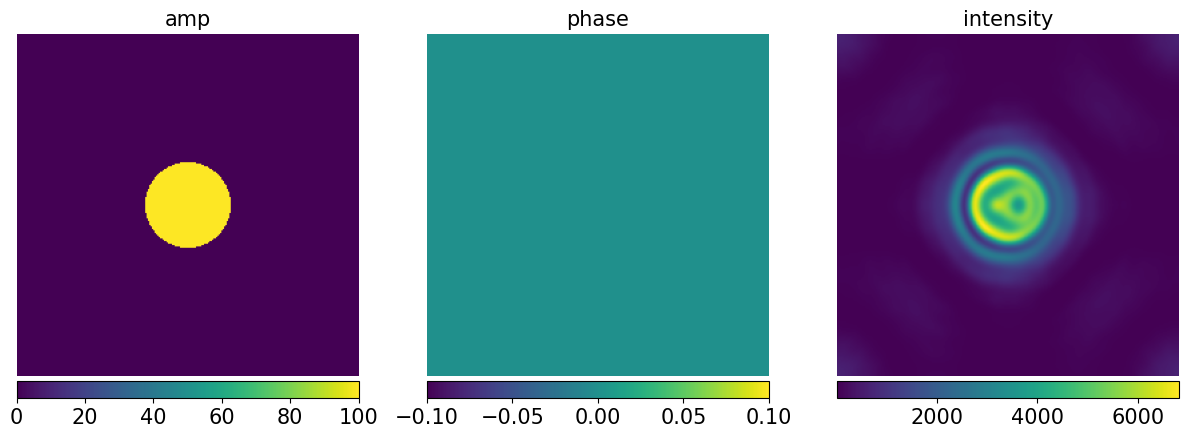

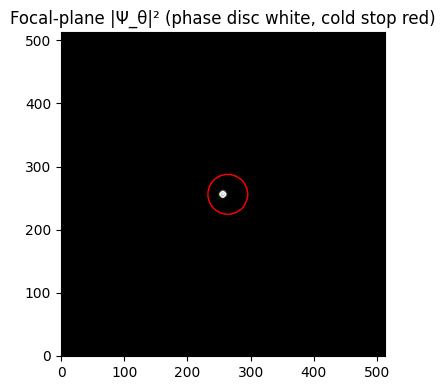

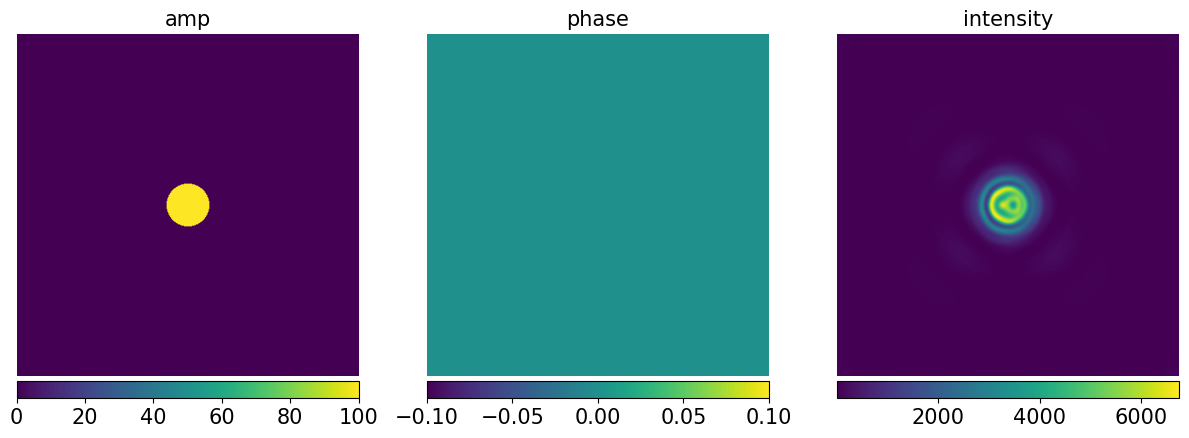

In [2]:
# Check they are consistent with different padding of input pupils, also  with cold stop offset 


#####
#number of focal plane samples is int(max(fplane_pixels,  zwfs_ns.grid.N )) 
# 

#####
for factor in [2,4,8]:
    grid_ns.dim = factor * zwfs_ns.grid.N # keep pupil size (zwfs_ns.grid.N) the same but increase padding
    # init again 
    zwfs_ns = bldr.init_zwfs(grid_ns, optics_ns, dm_ns)

    # init some input phase and amplitude 
    phi = 0 * zwfs_ns.grid.pupil_mask.T *  np.random.randn( *zwfs_ns.grid.pupil_mask.shape)
    amp = 1e2 * zwfs_ns.grid.pupil_mask.T

    ii = bldr.get_pupil_intensity(
        phi=phi, 
        amp=amp, 
        theta=zwfs_ns.optics.theta, 
        phasemask_diameter = zwfs_ns.optics.mask_diam, 
        phasemask_mask = None, # generate the correct correct mask from the specified diameter
        pupil_diameter = None, # this is not used , should check if we can remove it from the signature 
        fplane_pixels=256, 
        pixels_across_mask=20,
        coldstop_diam=8, 
        coldstop_offset=zwfs_ns.optics.coldstop_offset, #(1.0, 0.0), 
        coldstop_mask=None, # generate the correct mask from the coldstop diam specified
        include_beta=True, 
        return_field=False, 
        return_terms=False, 
        debug=True, #<- so we see the psf and cold stop and phasemask 
        )
    
    plt.show() #
    
    util.nice_heatmap_subplots( im_list=[amp, phi, ii], title_list=["amp","phase","intensity"])
    

In [18]:
ii.shape

(512, 512)

## Try get field, detect make sure consistent with get_frame (use_pyZelda=False) 

0.0408780574798584
0.03130388259887695


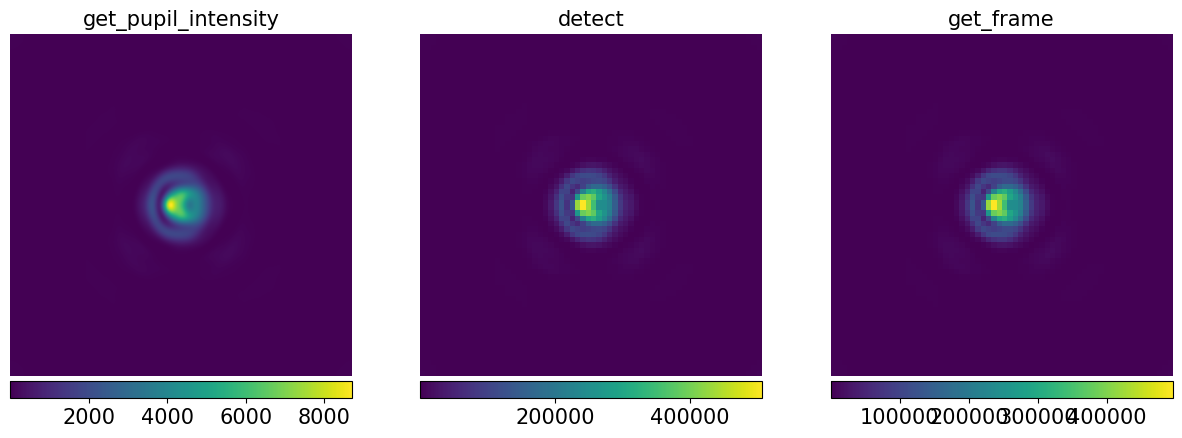

In [3]:


detector = bldr.detector(binning =8 ,dit=1,ron=1,qe=1)

ii = bldr.get_pupil_intensity(
    phi=phi, 
    amp=amp, 
    theta=zwfs_ns.optics.theta, 
    phasemask_diameter = zwfs_ns.optics.mask_diam, 
    phasemask_mask = None, # generate the correct correct mask from the specified diameter
    pupil_diameter = None, # this is not used , should check if we can remove it from the signature 
    fplane_pixels=256, 
    pixels_across_mask=20,
    coldstop_diam=4, 
    coldstop_offset=zwfs_ns.optics.coldstop_offset, 
    coldstop_mask=None, # generate the correct mask from the coldstop diam specified
    include_beta=True, 
    return_field=False, 
    return_terms=False, 
    debug=False, #<- so we see the psf and cold stop and phasemask 
    )


Ic = detector.detect( ii , include_shotnoise=False)
### issue here is by default get_frame uses the pre-computed phase mask 
Ic2 = bldr.get_frame( opd_input = 1.65e-6 * phi / (2*np.pi),  amp_input = amp ,  opd_internal = 0 * amp,  zwfs_ns = zwfs_ns , detector=detector, include_shotnoise=False , use_pyZelda = False)

util.nice_heatmap_subplots(im_list=[ii, Ic, Ic2], title_list=["get_pupil_intensity","detect", "get_frame"])

## # check flux  Conservation & time comparison between get frame with pyZelda (mft) and fft method

In [22]:
## INIT FROM PTYZELDA
config_ini = "/Users/bencb/Documents/ASGARD/BaldrApp/baldrapp/configurations/BALDR_UT_J3.ini" #proj_path  + '/baldrapp/configurations/BALDR_UT_J3.ini'#'/home/benja/Documents/BALDR/BaldrApp/configurations/BALDR_UT_J3.ini'
zwfs_pyZelda = bldr.init_zwfs_from_config_ini( config_ini=config_ini , wvl0=1.65e-6)

phi_pyzelda = 0 * zwfs_pyZelda.grid.pupil_mask *  np.random.randn( *zwfs_pyZelda.grid.pupil_mask.shape)
amp_pyzelda = 1e2 * zwfs_pyZelda.grid.pupil_mask

## TIME GET FRAME WITH PYZELDA
t0 = time.time()
Ic_pyzelda = bldr.get_frame( opd_input = 1.65e-6 * phi_pyzelda / (2*np.pi),  
                     amp_input = amp_pyzelda ,  
                     opd_internal = 0 * amp_pyzelda,  
                     zwfs_ns = zwfs_pyZelda , 
                     detector=detector, 
                     include_shotnoise=False , 
                     use_pyZelda = True)
t1 = time.time()
print(f"pyZelda=True get_frame for input field shape = {amp_pyzelda.shape}, took {t1-t0:.2f} seconds")

## TIME GET FRAME WITH OUR OWN MACHINARY (FFT)
grid_ns = SimpleNamespace(**grid_dict)
optics_ns = SimpleNamespace(**optics_dict)
dm_ns = SimpleNamespace(**dm_dict)

zwfs_ns = bldr.init_zwfs(grid_ns, optics_ns, dm_ns)

phi = 0 * zwfs_ns.grid.pupil_mask.T *  np.random.randn( *zwfs_ns.grid.pupil_mask.shape)
amp = 1e2 * zwfs_ns.grid.pupil_mask.T

t0 = time.time()
Ic2 = bldr.get_frame( opd_input = 1.65e-6 * phi / (2*np.pi),  
                     amp_input = amp ,  
                     opd_internal = 0 * amp,  
                     zwfs_ns = zwfs_ns , 
                     detector=detector, 
                     include_shotnoise=False , 
                     use_pyZelda = False)

t1 = time.time()
print(f"pyZelda=False get_frame for input field shape = {amp.shape}, took {t1-t0:.2f} seconds")




# check normalization 
print("\n\nFLUX CONSERVATION\n\n")
print(f"np.sum( Ic_pyzelda**0.5  ) / np.sum(amp_pyzelda) = {np.sum( Ic_pyzelda**0.5  ) / np.sum(amp_pyzelda)}")

print( f"np.sum( Ic2**0.5  ) / np.sum(amp) = {np.sum( Ic2**0.5  ) / np.sum(amp)}")


pyZelda=True get_frame for input field shape = (240, 240), took 0.05 seconds
0.010969161987304688
pyZelda=False get_frame for input field shape = (256, 256), took 0.07 seconds


FLUX CONSERVATION


np.sum( Ic_pyzelda**0.5  ) / np.sum(amp_pyzelda) = 2.6908993831921793
np.sum( Ic2**0.5  ) / np.sum(amp) = 0.3185360086994082


In [25]:
zwfs_pyZelda.pyZelda.pupil_diameter

144

# Now lets see some AO

In [133]:


im_dict = {}
for cs_offset in [0,0.5,1,1.5]:
    grid_dict = {
        "telescope":"DISC", #'AT',
        "D":1.8, # diameter of beam 
        "N" : 72, #64, # number of pixels across pupil diameter
        "dim": 72 * 4, #64 * 4 #4 
        #"padding_factor" : 4, # how many pupil diameters fit into grid x axis
        # TOTAL NUMBER OF PIXELS = padding_factor * N 
        }

    # I should include coldstop here!! 
    optics_dict = {
        "wvl0" :1.65e-6, # central wavelength (m) 
        "F_number": 21.2, # F number on phasemask
        "mask_diam": 1.06, # diameter of phaseshifting region in diffraction limit units (physical unit is mask_diam * 1.22 * F_number * lambda)
        "theta": 1.57079, # phaseshift of phasemask 
        ### NEw have not consistenty propagate this in functions in baldr_core
        "coldstop_diam": 4, #1.22 lambda/D units
        "coldstop_offset":(cs_offset, 0.0)
    }

    dm_dict = {
        "dm_model":"BMC-multi-3.5",
        "actuator_coupling_factor":0.7,# std of in actuator spacing of gaussian IF applied to each actuator. (e.g actuator_coupling_factor = 1 implies std of poke is 1 actuator across.)
        "dm_pitch":1,
        "dm_aoi":0, # angle of incidence of light on DM 
        "opd_per_cmd" : 3e-6, # peak opd applied at center of actuator per command unit (normalized between 0-1) 
        "flat_rmse" : 20e-9 # std (m) of flatness across Flat DM  
        }

    grid_ns = SimpleNamespace(**grid_dict)
    optics_ns = SimpleNamespace(**optics_dict)
    dm_ns = SimpleNamespace(**dm_dict)

    zwfs_ns = bldr.init_zwfs(grid_ns, optics_ns, dm_ns)


    # atmosphere 
    wvl0=1.65e-6 #m
    r0=0.1 #m
    L0 = 0.1 #m

    # stellar
    throughput = 1#0.1
    waveband = "H"
    magnitude = -5

    # detector 
    detector = bldr.detector(binning=6 ,dit=1.0,ron=1.0,qe=1.0)
    zwfs_ns.detector = detector


    basis_name = 'Zonal_pinned_edges'
    Nmodes = 100
    M2C_0 = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  

    # spatial differential in pupil space 
    dx = zwfs_ns.grid.D / zwfs_ns.grid.N
    # get required simulation sampling rate to match physical parameters 
    dt = dx * 10 / 30 #zwfs_ns.atmosphere.pixels_per_iteration / zwfs_ns.atmosphere.v # s # simulation sampling rate

    scrn = ps.PhaseScreenKolmogorov(nx_size=zwfs_ns.grid.dim, pixel_scale=dx, r0=0.1, L0=25, random_seed=1)
    phase_scaling_factor = 0.3

    # Build the interaction matrix and register the DM in pixel space:
    basis_name =  "Zonal_pinned_edges"
    Nmodes = 100
    M2C_0 = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  

    ## in the bldr version IM requires classify regions etc, lets just do ours manually 



    ####### LETS BUILD IT MANUALLY 
    calibration_opd_input=0 * np.zeros_like(zwfs_ns.grid.pupil_mask)

    calibration_amp_input=(throughput *
                (np.pi * (zwfs_ns.grid.D/2)**2) / 
                (np.pi * (zwfs_ns.grid.N/2)**2) *
                util.magnitude_to_photon_flux(magnitude=magnitude,
                                                band=waveband,
                                                wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask

    opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)

    poke_amp=0.05
    poke_method='double_sided_poke'
    basis_name =  "Zonal"
    imgs_to_mean=10


    use_pyZelda = False 




    # build reconstructor name space with normalized basis, IM generated, IM generation method, pokeamp 
    modal_basis = DM_basis.construct_command_basis( basis= basis_name , number_of_modes = Nmodes, without_piston=True).T 

    IM=[] # init our raw interaction matrix 

    I0_list = []
    for _ in range(imgs_to_mean) :
        I0_list .append( bldr.get_I0( opd_input  =calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda )  )
    I0 = np.mean( I0_list ,axis =0 )

    N0_list = []
    for _ in range(imgs_to_mean) :
        N0_list.append( bldr.get_N0( opd_input  = calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda )  )
    N0 = np.mean( N0_list ,axis =0 )

    if poke_method=='single_sided_poke': # just poke one side  
                

        for i,m in enumerate(modal_basis):
            print(f'executing cmd {i}/{len(modal_basis)}')       
                
            zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + poke_amp * m
            
            img_list = []
            for _ in range( imgs_to_mean ):
                img_list.append( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = use_pyZelda) ) # get some frames 
                    
            Intensity = np.mean( img_list, axis = 0).reshape(-1) 

            # IMPORTANT : we normalize by mean over total image region (post reduction) (NOT FILTERED )... 
            Intensity *= 1/np.mean( Intensity ) # we normalize by mean over total region! 
            
            # get intensity error signal 
            errsig = bldr.process_zwfs_signal( Intensity, I0, np.ones_like(  I0 ).astype(bool) )

            IM.append( list(  errsig.reshape(-1) ) ) #toook out 1/poke_amp *

    elif poke_method=='double_sided_poke':
        for i,m in enumerate(modal_basis):
            print(f'executing cmd {i}/{len(modal_basis)}')
            I_plus_list = []
            I_minus_list = []
            for sign in [(-1)**n for n in range(np.max([2, imgs_to_mean]))]: #[-1,1]:
                
                #ZWFS.dm.send_data( list( ZWFS.dm_shapes['flat_dm'] + sign * poke_amp/2 * m )  )
                zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + sign * poke_amp/2 * m
                
                if sign > 0:
                    
                    I_plus_list += [list( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = use_pyZelda) ) ]
                    
                if sign < 0:
                    
                    I_minus_list += [list( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector, use_pyZelda = use_pyZelda ) ) ] 
                    

            I_plus = np.mean( I_plus_list, axis = 0).reshape(-1)  # flatten so can filter with ZWFS.pupil_pixels
            I_plus *= 1/np.mean( I_plus )

            I_minus = np.mean( I_minus_list, axis = 0).reshape(-1)  # flatten so can filter with ZWFS.pupil_pixels
            I_minus *= 1/np.mean( I_minus )

            errsig =  (I_plus - I_minus)[np.array( np.ones_like( I0 ).astype(bool).reshape(-1) )]
            IM.append( list(  errsig.reshape(-1) ) ) #toook out 1/poke_amp *

    else:
        raise TypeError( ' no matching method for building control model. Try (for example) method="single_side_poke"')

    # convert to array 
    IM = np.array( IM )  

    reco_dict = {
        "I0":I0,
        "N0":N0,
        "M2C_0":modal_basis,
        "basis_name":basis_name,
        "poke_amp":poke_amp,
        "poke_method":poke_method,
        "IM":IM,
    }

    im_dict[cs_offset] = reco_dict
    
    # reco_ns = SimpleNamespace(**reco_dict)

    # zwfs_ns.reco = reco_ns


    # ##### LOOK AT EIGEN VECTORS 
    # U, S, Vt = np.linalg.svd( zwfs_ns.reco.IM, full_matrices=False)

    # #Vt.shape
    # plt.figure() 
    # plt.loglog( S )

    # util.nice_heatmap_subplots( im_list=[vv.reshape(48,48) for vv in Vt[:8]])
    # util.nice_heatmap_subplots( im_list=[vv.reshape(48,48) for vv in Vt[8:16]])
    # util.nice_heatmap_subplots( im_list=[vv.reshape(48,48) for vv in Vt[16:24]])
    # plt.show()

0.009037256240844727
0.00971078872680664
0.009466171264648438
0.009566307067871094
0.009451150894165039
0.009613752365112305
0.009320974349975586
0.009124755859375
0.009471893310546875
0.009578943252563477
0.009213924407958984
0.008931875228881836
0.008635282516479492
0.008744955062866211
0.009675741195678711
0.009643077850341797
0.009710073471069336
0.009407997131347656
0.009259939193725586
0.009402990341186523
executing cmd 0/140
0.00990915298461914
0.009855985641479492
0.009736061096191406
0.009372949600219727
0.009669065475463867
0.009624004364013672
0.009610891342163086
0.009613990783691406
0.009182214736938477
0.010206937789916992
executing cmd 1/140
0.009824991226196289
0.010496854782104492
0.011934995651245117
0.011116981506347656
0.00997304916381836
0.009994029998779297
0.009890079498291016
0.0100250244140625
0.010350942611694336
0.009499073028564453
executing cmd 2/140
0.010484933853149414
0.009811162948608398
0.009673118591308594
0.00947880744934082
0.009348154067993164
0.00

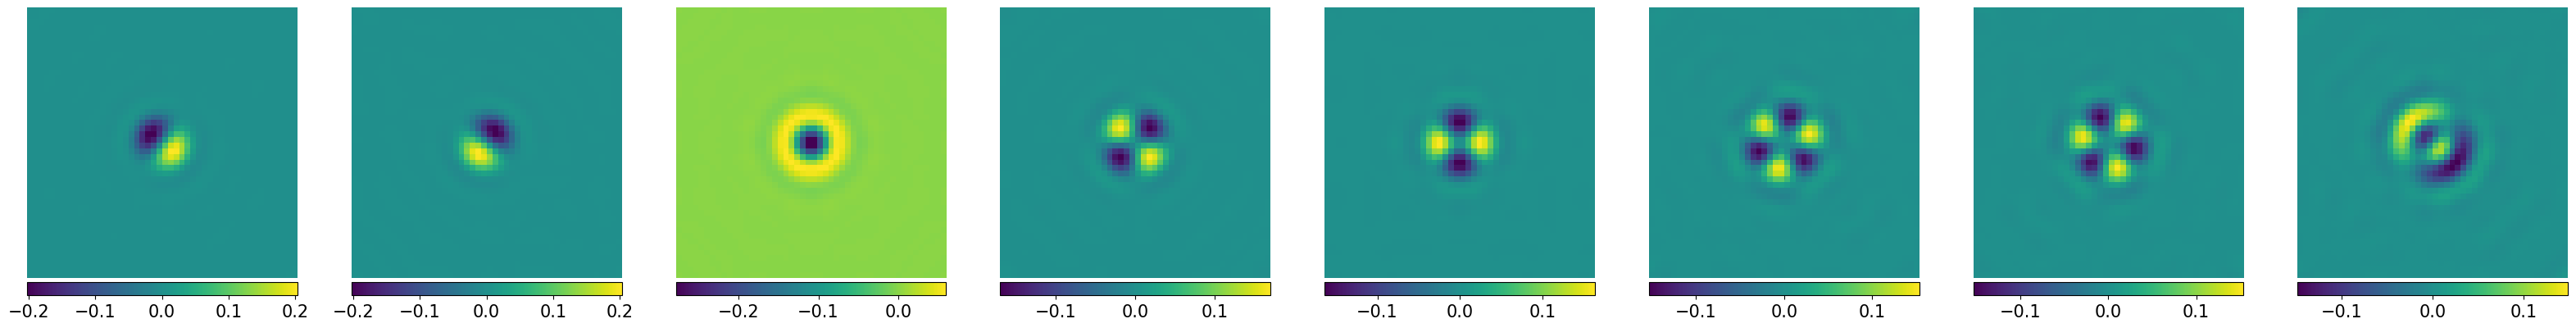

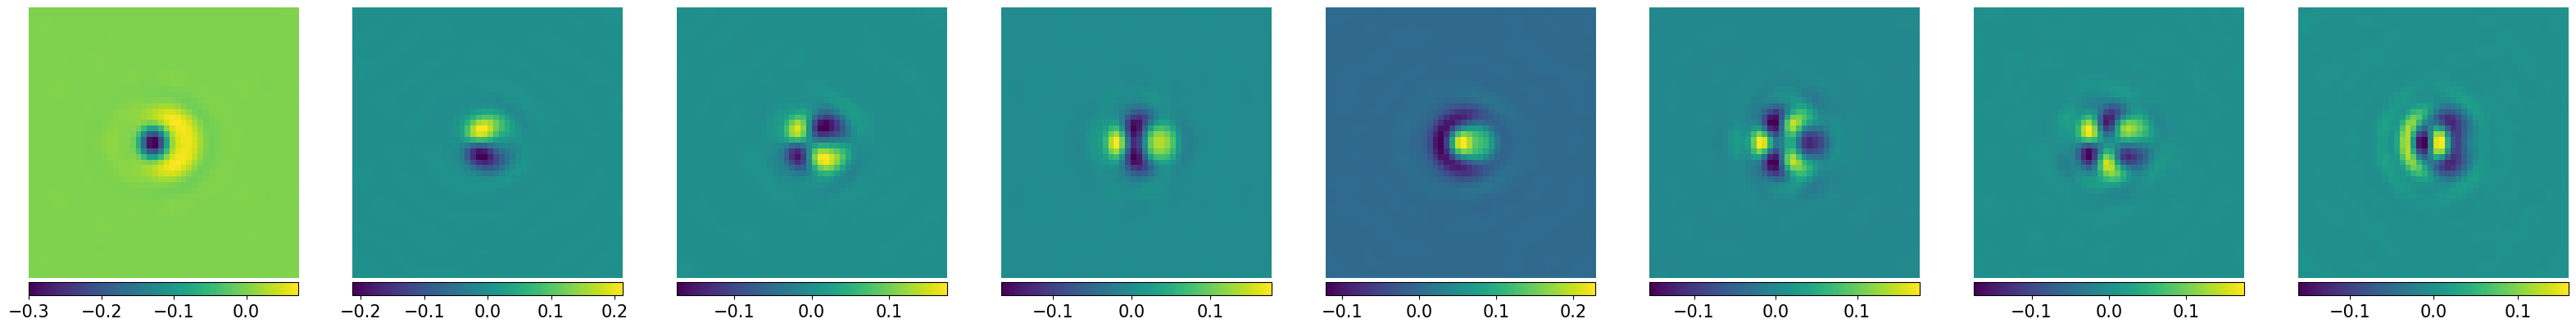

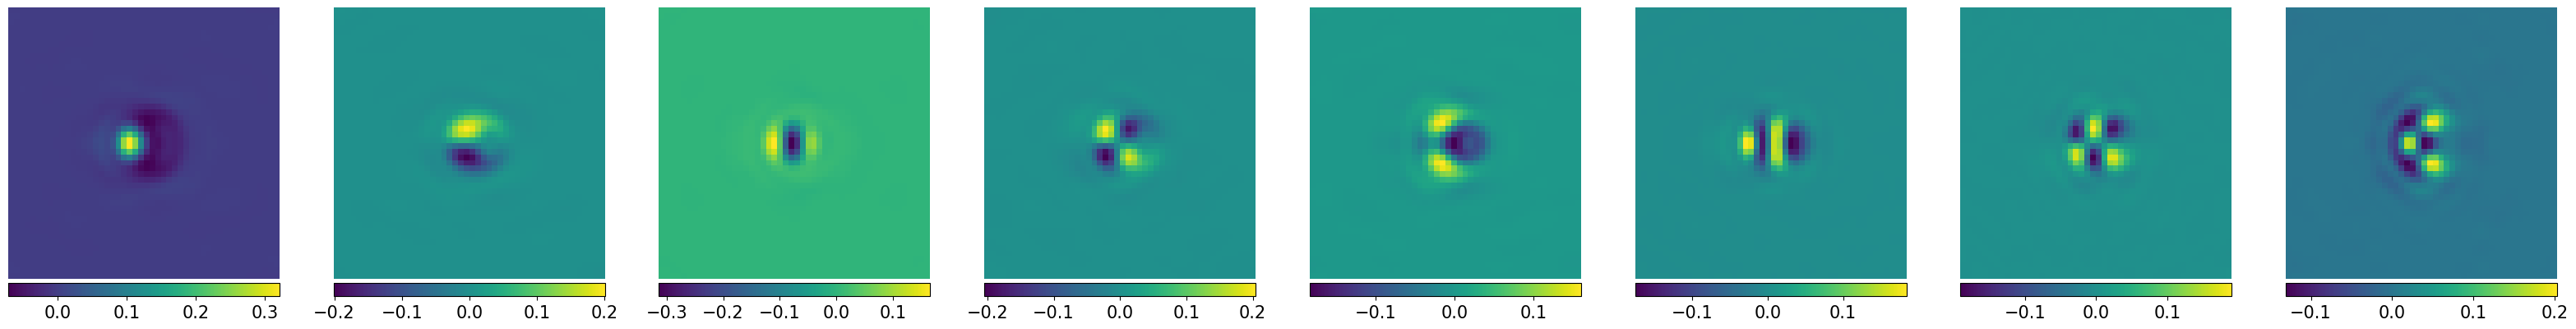

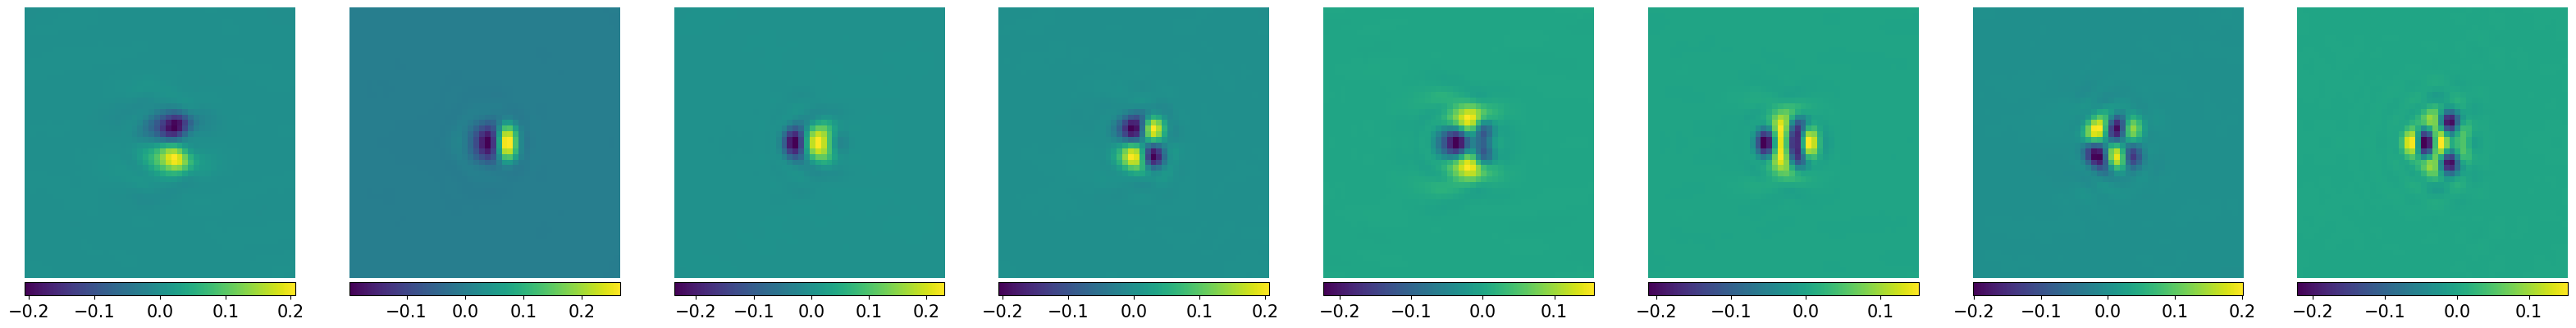

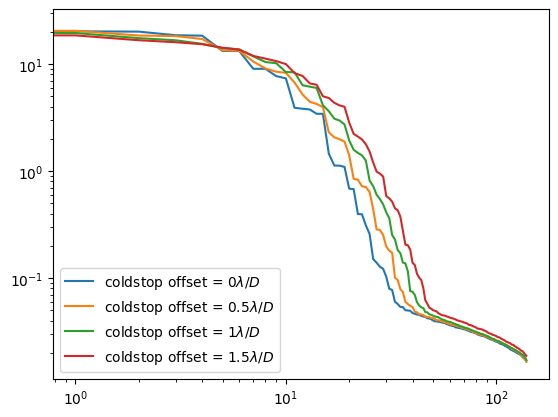

In [134]:
S_list = []
for cs_offset in im_dict:
    U, S, Vt = np.linalg.svd( im_dict[cs_offset]["IM"], full_matrices=False)
    #plt.figure() 
    #plt.loglog( S )

    util.nice_heatmap_subplots( im_list=[vv.reshape(48,48) for vv in Vt[:8]])
    #util.nice_heatmap_subplots( im_list=[vv.reshape(64,64) for vv in Vt[8:16]])
    #util.nice_heatmap_subplots( im_list=[vv.reshape(64,64) for vv in Vt[16:24]])
    plt.show()

plt.figure() 
for cs_offset in im_dict:
    U, S, Vt = np.linalg.svd( im_dict[cs_offset]["IM"], full_matrices=False)
    #plt.figure() 
    plt.loglog( S , label = rf"coldstop offset = {cs_offset}$\lambda/D$" )

plt.legend()
plt.show()

coldstop diam = 4 lambda/D, ~12 pixel sampling across the pupil, we see more modes with larger coldstop offset due to leakage of higher order modes through the cold stop.

## Reconstructor

In [617]:
grid_dict = {
    "telescope":"DISC", #'AT',
    "D":1.8, # diameter of beam 
    "N" : 72, #64, # number of pixels across pupil diameter
    "dim": 72 * 4, #64 * 4 #4 
    #"padding_factor" : 4, # how many pupil diameters fit into grid x axis
    # TOTAL NUMBER OF PIXELS = padding_factor * N 
    }

# I should include coldstop here!! 
optics_dict = {
    "wvl0" :1.65e-6, # central wavelength (m) 
    "F_number": 21.2, # F number on phasemask
    "mask_diam": 1.06, # diameter of phaseshifting region in diffraction limit units (physical unit is mask_diam * 1.22 * F_number * lambda)
    "theta": 1.57079, # phaseshift of phasemask 
    ### NEw have not consistenty propagate this in functions in baldr_core
    "coldstop_diam": 8, #1.22 lambda/D units
    "coldstop_offset":(0.0, 0.0)
}

dm_dict = {
    "dm_model":"BMC-multi-3.5",
    "actuator_coupling_factor":0.7,# std of in actuator spacing of gaussian IF applied to each actuator. (e.g actuator_coupling_factor = 1 implies std of poke is 1 actuator across.)
    "dm_pitch":1,
    "dm_aoi":0, # angle of incidence of light on DM 
    "opd_per_cmd" : 3e-6, # peak opd applied at center of actuator per command unit (normalized between 0-1) 
    "flat_rmse" : 20e-9 # std (m) of flatness across Flat DM  
    }

grid_ns = SimpleNamespace(**grid_dict)
optics_ns = SimpleNamespace(**optics_dict)
dm_ns = SimpleNamespace(**dm_dict)

zwfs_ns = bldr.init_zwfs(grid_ns, optics_ns, dm_ns)


# atmosphere 
wvl0=1.65e-6 #m
r0=0.1 #m
L0 = 0.1 #m

# stellar
throughput = 1 #0.1
waveband = "H" 
magnitude = -5

# detector 
detector = bldr.detector(binning=6 ,dit=1.0,ron=1.0,qe=1.0)
zwfs_ns.detector = detector


basis_name = 'Zonal_pinned_edges'
Nmodes = 100
M2C_0 = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  

# spatial differential in pupil space 
dx = zwfs_ns.grid.D / zwfs_ns.grid.N
# get required simulation sampling rate to match physical parameters 
dt = dx * 10 / 30 #zwfs_ns.atmosphere.pixels_per_iteration / zwfs_ns.atmosphere.v # s # simulation sampling rate

scrn = ps.PhaseScreenKolmogorov(nx_size=zwfs_ns.grid.dim, pixel_scale=dx, r0=0.1, L0=25, random_seed=1)
phase_scaling_factor = 0.3

# Build the interaction matrix and register the DM in pixel space:
basis_name =  "Zonal_pinned_edges"
Nmodes = 100
M2C_0 = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  

## in the bldr version IM requires classify regions etc, lets just do ours manually 



####### LETS BUILD IT MANUALLY 
calibration_opd_input=0 * np.zeros_like(zwfs_ns.grid.pupil_mask)

calibration_amp_input=(throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask

opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)

poke_amp=0.05
poke_method="double_sided_poke"
basis_name = "Zonal"
imgs_to_mean=10


use_pyZelda = False 




# build reconstructor name space with normalized basis, IM generated, IM generation method, pokeamp 
modal_basis = DM_basis.construct_command_basis( basis= basis_name , number_of_modes = Nmodes, without_piston=True).T 

IM=[] # init our raw interaction matrix 

I0_list = []
for _ in range(imgs_to_mean) :
    I0_list .append( bldr.get_I0( opd_input  =calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda )  )
I0 = np.mean( I0_list ,axis =0 )

N0_list = []
for _ in range(imgs_to_mean) :
    N0_list.append( bldr.get_N0( opd_input  = calibration_opd_input,    amp_input = calibration_amp_input  ,  opd_internal= opd_internal,  zwfs_ns=zwfs_ns , detector=detector, use_pyZelda = use_pyZelda )  )
N0 = np.mean( N0_list ,axis =0 )

if poke_method=='single_sided_poke': # just poke one side  
            

    for i,m in enumerate(modal_basis):
        print(f'executing cmd {i}/{len(modal_basis)}')       
            
        zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + poke_amp * m
        
        img_list = []
        for _ in range( imgs_to_mean ):
            img_list.append( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = use_pyZelda) ) # get some frames 
                
        Intensity = np.mean( img_list, axis = 0).reshape(-1) 

        # IMPORTANT : we normalize by mean over total image region (post reduction) (NOT FILTERED )... 
        Intensity *= 1/np.mean( Intensity ) # we normalize by mean over total region! 
        
        # get intensity error signal 
        errsig = bldr.process_zwfs_signal( Intensity, I0, np.ones_like(  I0 ).astype(bool) )

        IM.append( list(  errsig.reshape(-1) ) ) #toook out 1/poke_amp *

elif poke_method=='double_sided_poke':
    for i,m in enumerate(modal_basis):
        print(f'executing cmd {i}/{len(modal_basis)}')
        I_plus_list = []
        I_minus_list = []
        for sign in [(-1)**n for n in range(np.max([2, imgs_to_mean]))]: #[-1,1]:
            
            #ZWFS.dm.send_data( list( ZWFS.dm_shapes['flat_dm'] + sign * poke_amp/2 * m )  )
            zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + sign * poke_amp/2 * m
            
            if sign > 0:
                
                I_plus_list += [list( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = use_pyZelda) ) ]
                
            if sign < 0:
                
                I_minus_list += [list( bldr.get_frame( calibration_opd_input,   calibration_amp_input  ,  opd_internal,  zwfs_ns , detector=detector, use_pyZelda = use_pyZelda ) ) ] 
                

        I_plus = np.mean( I_plus_list, axis = 0).reshape(-1)  # flatten so can filter with ZWFS.pupil_pixels
        I_plus *= 1/np.mean( I_plus )

        I_minus = np.mean( I_minus_list, axis = 0).reshape(-1)  # flatten so can filter with ZWFS.pupil_pixels
        I_minus *= 1/np.mean( I_minus )

        errsig =  (I_plus - I_minus)[np.array( np.ones_like( I0 ).astype(bool).reshape(-1) )]
        IM.append( list(  errsig.reshape(-1) ) ) #toook out 1/poke_amp *

else:
    raise TypeError( ' no matching method for building control model. Try (for example) method="single_side_poke"')

# convert to array 
IM = np.array( IM )  

reco_dict = {
    "I0":I0,
    "N0":N0,
    "M2C_0":modal_basis,
    "basis_name":basis_name,
    "poke_amp":poke_amp,
    "poke_method":poke_method,
    "IM":IM,
}





0.009469032287597656
0.009330987930297852
0.010498762130737305
0.010336875915527344
0.01018071174621582
0.010242223739624023
0.010308027267456055
0.010198116302490234
0.010210990905761719
0.011600017547607422
0.009570121765136719
0.010044097900390625
0.010859012603759766
0.010003328323364258
0.009463071823120117
0.009036779403686523
0.009519815444946289
0.009387969970703125
0.009206056594848633
0.008987188339233398
executing cmd 0/140
0.009594202041625977
0.009275197982788086
0.01042628288269043
0.010175943374633789
0.011048078536987305
0.010857820510864258
0.010386943817138672
0.009717226028442383
0.009615182876586914
0.009550094604492188
executing cmd 1/140
0.009308338165283203
0.009797096252441406
0.009785175323486328
0.010563850402832031
0.011005163192749023
0.01036381721496582
0.010408878326416016
0.010035991668701172
0.011703729629516602
0.010840892791748047
executing cmd 2/140
0.010637283325195312
0.009631156921386719
0.010197162628173828
0.009523868560791016
0.01086902618408203

## Finding optimal regularisation and number of modes 

0.009281158447265625
0.014979839324951172
0.016592979431152344
0.014000177383422852
0.02048492431640625
0.022214889526367188
0.010886192321777344
0.015086889266967773
0.00962519645690918
0.01738595962524414
0.015399932861328125
0.022745132446289062
0.014713764190673828
0.01036524772644043
0.02068805694580078
0.016927242279052734
0.016656160354614258
0.01582789421081543
0.01771378517150879
0.01491093635559082
0.011130094528198242
0.017305850982666016
0.012526988983154297
0.025346994400024414
0.016208887100219727
0.009704113006591797
0.012480020523071289
0.011881828308105469
0.014199018478393555
0.00999593734741211
0.016434907913208008
0.016782045364379883
0.017103910446166992
0.009890079498291016
0.011636018753051758
0.010593175888061523
0.017766237258911133
0.02811574935913086
0.01058506965637207
0.011254072189331055
0.009739160537719727
0.021448850631713867
0.013355016708374023
0.009837150573730469
0.01116180419921875
0.024063825607299805
0.009972810745239258
0.009731769561767578
0.01

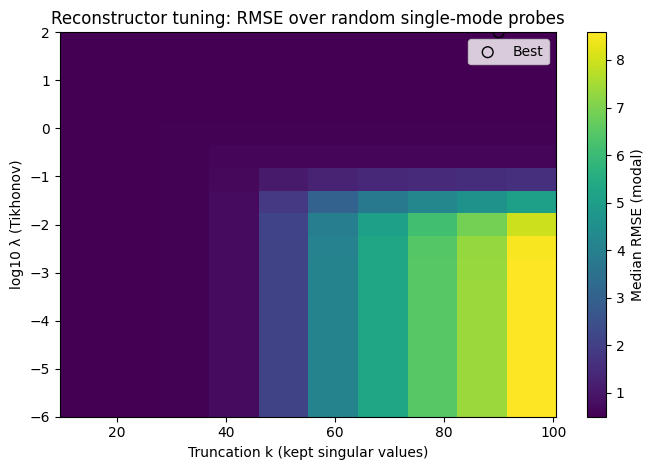

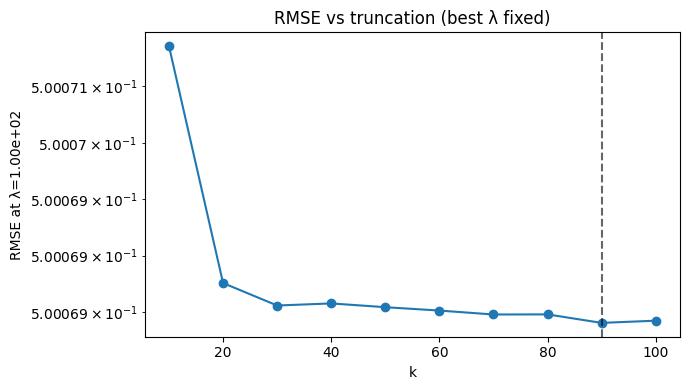

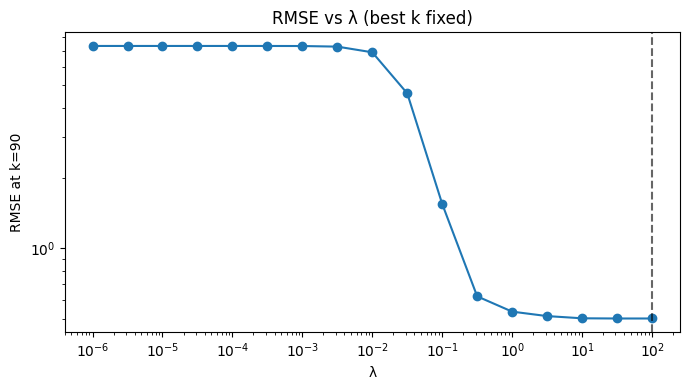

0.016550064086914062


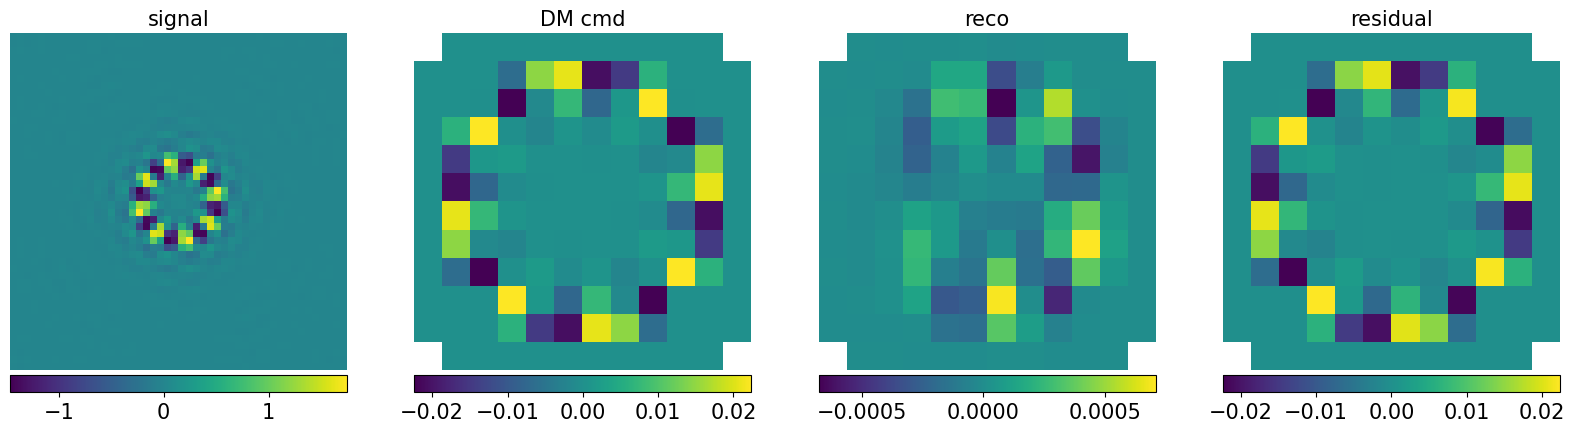

In [ ]:

basis_name =  "Zernike"
Nmodes = 100
probe_basis = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  


calibration_opd_input=0 * np.zeros_like(zwfs_ns.grid.pupil_mask)

calibration_amp_input=(throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask

opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)


# zero DM 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

# get reference intensity
I0 = bldr.get_frame( 0 * opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)
I0 /= np.mean(I0)

# ---------------- Setup: basis and helpers ----------------
Nmodes = probe_basis.shape[0]          # probe_basis: (Nmodes × Nact) row-modes (as in your code)
M2C = probe_basis.T                    # (Nact × Nmodes) maps modal coeffs -> DM commands
V = Vt.T                               # from your SVD(A)

# Ensure mask matches how A was built
I0_vec = I0.reshape(-1)
mask_pixels = np.ones_like(I0_vec, dtype=bool)  # replace with your actual mask if you used one in A

# ---------------- Sweep grid ----------------
lam_vals = np.logspace(-6, 2, 17)              # Tikhonov grid
k_vals   = np.unique(np.clip([10,20,30,40,50,60,70,80,90,100], 1, len(S)))

n_probes = 50                                   # how many random probe modes to median over
poke_amp = 0.10                                 # small, linear regime

rmse_dict = {}  # rmse_dict[mode_idx][lam][k] = RMSE


for _ in range(n_probes):

    m = int(np.random.uniform(low=0, high=Nmodes))
    rmse_dict.setdefault(m, {})

    # Apply a single-mode probe on the internal source
    c_true = np.zeros(Nmodes); c_true[m] = poke_amp           # modal ground truth
    u_true = M2C @ c_true                                     # actuator vector
    zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + u_true

    # Measure frame and normalize exactly like for A/I0
    ii = bldr.get_frame(calibration_opd_input,
                        calibration_amp_input,
                        opd_internal,
                        zwfs_ns, detector=detector,
                        use_pyZelda=False).astype(float)
    ii /= ii.mean()

    y_err = (ii.reshape(-1) - I0_vec)[mask_pixels]            # pixel error (masked)

    # Grid search over (lam, k)
    for lam in lam_vals:
        rmse_dict[m].setdefault(lam, {})
        Wsig = S / (S*S + lam*lam)                            # Tikhonov
        for k in k_vals:
            Wk = Wsig.copy()
            if k < len(Wk): Wk[k:] = 0.0                      # hard truncation after k

            # Reconstructor R maps pixels->modes
            R = V @ (Wk[:, None] * U.T)                       # (Nmodes × Npix_eff)

            c_hat = R.T @ y_err    
            r_modal = zwfs_ns.dm.current_cmd - c_hat                             # (Nmodes,)
            ## this is wrong ## r_modal = (poke_amp * (np.arange(Nmodes)==m).astype(float)) - c_hat
            rmse = np.sqrt(np.mean(r_modal**2))
            rmse_dict[m][lam][int(k)] = float(rmse)

# ---------------- Aggregate across probes & pick best ----------------
# Build an array: median RMSE over probe modes for each (lam,k)
rmse_grid = np.full((len(lam_vals), len(k_vals)), np.nan)
for i, lam in enumerate(lam_vals):
    for j, k in enumerate(k_vals):
        vals = []
        for m in rmse_dict:
            if lam in rmse_dict[m] and k in rmse_dict[m][lam]:
                vals.append(rmse_dict[m][lam][k])
        if vals:
            rmse_grid[i, j] = np.median(vals)

best_idx = np.nanargmin(rmse_grid)
i_best, j_best = np.unravel_index(best_idx, rmse_grid.shape)
lam_best, k_best = lam_vals[i_best], k_vals[j_best]
print(f"Best λ={lam_best:.3e}, k={k_best:d}, median RMSE={rmse_grid[i_best,j_best]:.3e}")

# ---------------- Plots ----------------
plt.figure(figsize=(7,4.8))
im = plt.imshow(rmse_grid, origin='lower', aspect='auto',
                extent=[k_vals[0]-0.5, k_vals[-1]+0.5, np.log10(lam_vals[0]), np.log10(lam_vals[-1])])
plt.colorbar(im, label="Median RMSE (modal)")
plt.scatter([k_best], [np.log10(lam_best)], s=60, marker='o', edgecolor='k', facecolor='none', label='Best')
plt.xlabel("Truncation k (kept singular values)")
plt.ylabel("log10 λ (Tikhonov)")
plt.title("Reconstructor tuning: RMSE over random single-mode probes")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.semilogy(k_vals, rmse_grid[i_best, :], marker='o')
plt.axvline(k_best, ls='--', color='k', alpha=0.6)
plt.xlabel("k")
plt.ylabel(f"RMSE at λ={lam_best:.2e}")
plt.title("RMSE vs truncation (best λ fixed)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.loglog(lam_vals, rmse_grid[:, j_best], marker='o')
plt.axvline(lam_best, ls='--', color='k', alpha=0.6)
plt.xlabel("λ")
plt.ylabel(f"RMSE at k={k_best:d}")
plt.title("RMSE vs λ (best k fixed)")
plt.tight_layout()
plt.show()

# ---------------- Inspect a probe at the best params ----------------
# Rebuild R at best (optional quick check)
Wsig = S / (S*S + lam_best*lam_best)
Wk = Wsig.copy()
if k_best < len(Wk): Wk[k_best:] = 0.0
R_best = V @ (Wk[:, None] * U.T)

# pick one probe from rmse_dict to visualize
m_show = next(iter(rmse_dict.keys()))
# Re-run that probe
c_true = np.zeros(Nmodes); c_true[m_show] = poke_amp
u_true = M2C @ c_true
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + u_true
ii = bldr.get_frame(calibration_opd_input, calibration_amp_input, opd_internal,
                    zwfs_ns, detector=detector, use_pyZelda=False).astype(float)
ii /= ii.mean()
y_err = (ii.reshape(-1) - I0_vec)[mask_pixels]
c_hat = R_best.T @ y_err

residual = u_true - c_hat
# quick modal diagnostic
im_list=[ii-I0 , 
        util.get_DM_command_in_2D(u_true), 
        util.get_DM_command_in_2D(c_hat) , 
        util.get_DM_command_in_2D(residual)]

title_list=['signal', 
        'DM cmd', 
        'reco' , 
        'residual']


util.nice_heatmap_subplots(im_list = im_list, title_list = title_list) ;plt.show()

upsample it scintillation screen
0.010341167449951172
0.015455007553100586
0.010150909423828125
opd res_before 2.2020922536367982e-07 m
opd res_after 1.9074648379941793e-07 m
strehl before 0.4950115907254193
strehl after 0.590019215402789


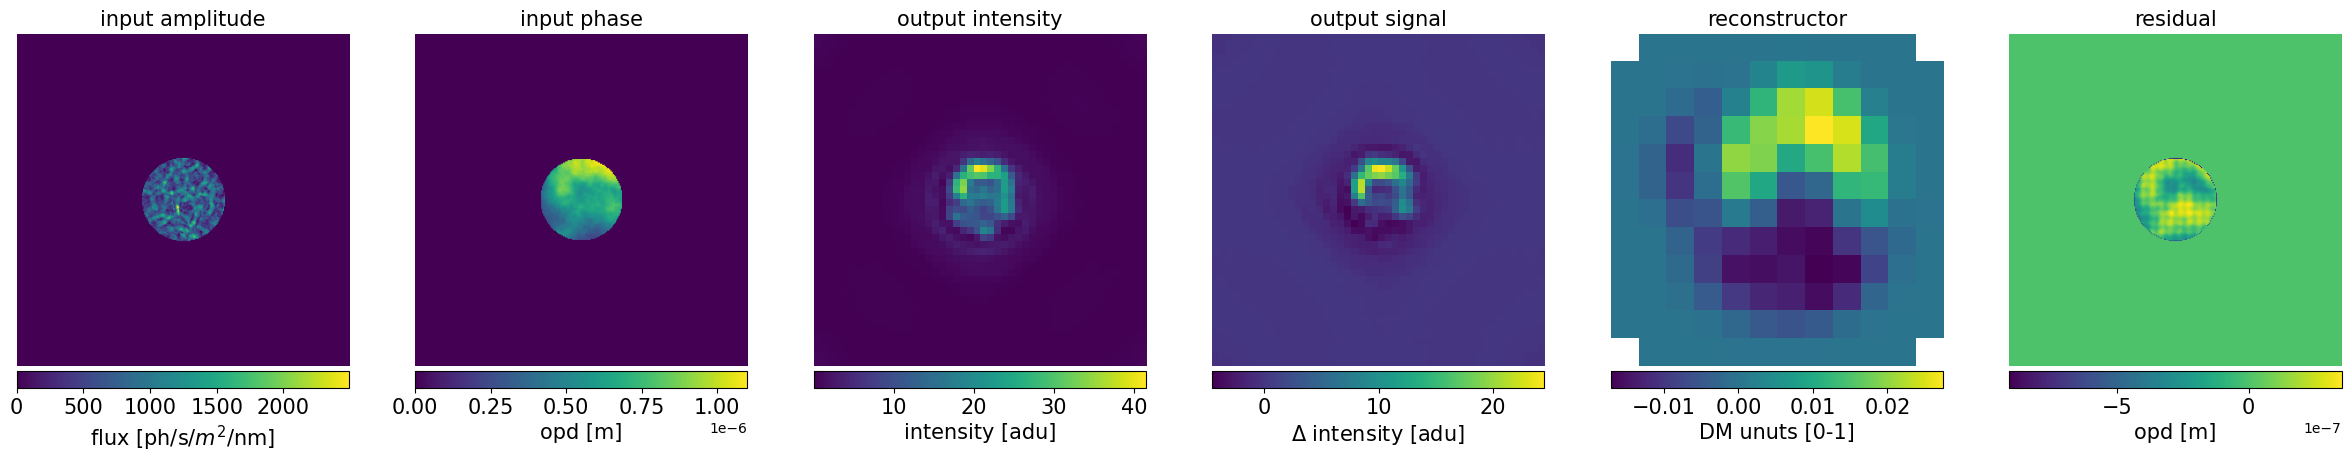

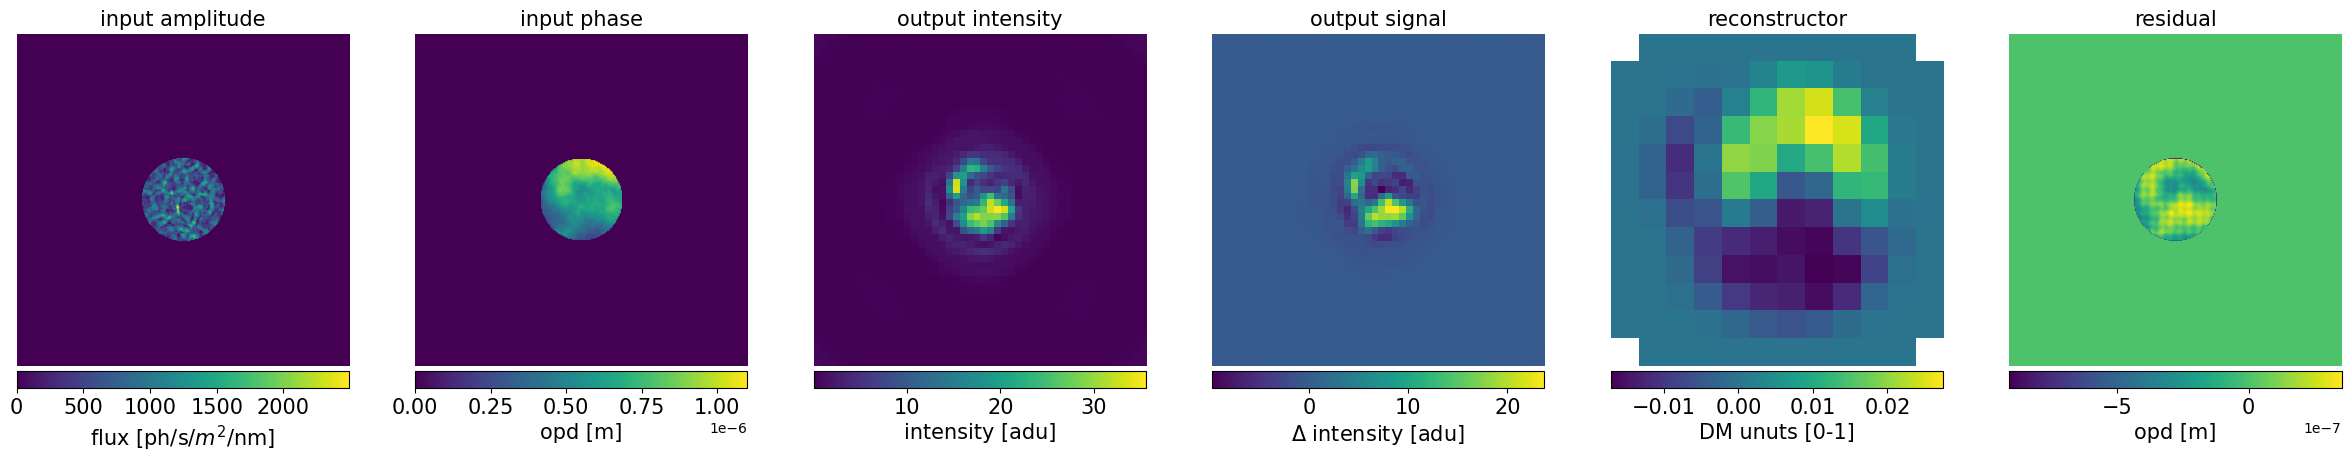

In [ ]:

## now create an aberration and input 
basis_cropped = ztools.zernike.zernike_basis(nterms=50, npix=zwfs_ns.grid.N)
# we have padding around telescope pupil (check zwfs_ns.pyZelda.pupil.shape and zwfs_ns.pyZelda.pupil_diameter) 
# so we need to put basis in the same frame  
basis_template = np.zeros( zwfs_ns.grid.pupil_mask.shape )
basis = np.array( [ util.insert_concentric( np.nan_to_num(b, 0), basis_template) for b in basis_cropped] )


r0_scint = 0.164
L0_scint  = 10

r0 = (0.164) * (1.65/0.5)**(6/5)
L0  = 25

scrn = ps.PhaseScreenKolmogorov(nx_size=zwfs_ns.grid.dim, pixel_scale=dx, r0=r0, L0=L0, random_seed=2)
phase_scaling_factor = 0.7



#stencil_length_factor = 2**7 #4 #32
scint_phasescreen =  aotools.turbulence.infinitephasescreen.PhaseScreenVonKarman(nx_size=zwfs_ns.grid.dim, pixel_scale=dx, r0 = r0_scint, L0 = L0_scint)



# first stage AO
#if np.mod(it, 1) == 0: # only update the AO every few iterations to simulate latency 
_ , reco_1 = bldr.first_stage_ao( scrn, Nmodes_removed = 0 , basis = basis , phase_scaling_factor = phase_scaling_factor, return_reconstructor = True )   
    
ao_1 =  basis[0] * (phase_scaling_factor * scrn.scrn - reco_1)




opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)

opd_input = phase_scaling_factor * wvl0 / (2*np.pi) * ao_1  #scrn.scrn #0.3 * wvl0 / (2*np.pi) * basis[1] 

amp_input=(throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask


amp_input *= update_scintillation( high_alt_phasescreen=scint_phasescreen , pxl_scale=dx, wavelength=wvl0, final_size = None,jumps = 1,propagation_distance=10000)




###### RECONSTRUCTOR 
V = Vt.T

# Regularization / truncation knobs:
lam = 100             # Tikhonov (set >0 if needed)
#smin = 1e-2 * S.max()    # optional hard gate
smin_idx = 80
# diagonal inverse weights for Σ (Tikhonov)
W = S / (S*S + lam*lam)
#W[S < smin] = 0.0
W[smin_idx:] = 0.0
# Reconstructor mapping pixel error -> modal coefficients (Nmodes × Npix_eff)
R_modal = V @ (W[:,None] * U.T)    # c_hat = R_modal @ y_err_eff




I0 = bldr.get_frame( 0 * opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)
I0 /= np.mean(I0)
#N0 = bldr.get_frame( 0 * opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False) 

ii = bldr.get_frame( opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) 
ii /= np.mean(ii)



y_err = (ii - I0).reshape(-1)  # must match how A was built

# Modal estimate (per your basis order)
c_hat = R_modal.T @ y_err    # shape: (Nmodes,)

# Map modal -> DM commands
M2C = modal_basis.T        # (Nact × Nmodes) if modal_basis is (Nmodes × Nact) row-modes; adjust if different
u_cmd = M2C @ c_hat

opd_current_dm_before = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
            sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


res_before = opd_input + opd_current_dm_before
res_before = res_before- np.mean( res_before[ zwfs_ns.grid.pupil_mask.astype(bool)] )


# apply it 
# Optionally send to DM (in sim):
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat - 1 * u_cmd

# 
opd_current_dm_after = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
            sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )



res_after = opd_input + opd_current_dm_after
res_after = res_after - np.mean( res_after[ zwfs_ns.grid.pupil_mask.astype(bool)] )


util.nice_heatmap_subplots(im_list=[amp_input,zwfs_ns.grid.pupil_mask *  opd_input,ii, ii-I0, util.get_DM_command_in_2D(u_cmd), zwfs_ns.grid.pupil_mask * res_after], #c_hat)], 
                           title_list=["input amplitude","input phase","output intensity","output signal","reconstructor","residual"],
                            cbar_label_list=[f"flux [ph/s/$m^2$/nm]", "opd [m]","intensity [adu]",r"$\Delta$ intensity [adu]","DM unuts [0-1]","opd [m]"])



ii = bldr.get_frame( opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) 
ii /= np.mean(ii)


util.nice_heatmap_subplots(im_list=[amp_input,zwfs_ns.grid.pupil_mask *  opd_input,ii, ii-I0, util.get_DM_command_in_2D(u_cmd), zwfs_ns.grid.pupil_mask * res_after], #c_hat)], 
                           title_list=["input amplitude","input phase","output intensity","output signal","reconstructor","residual"],
                            cbar_label_list=[f"flux [ph/s/$m^2$/nm]", "opd [m]","intensity [adu]",r"$\Delta$ intensity [adu]","DM unuts [0-1]","opd [m]"])


# return to flat 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

print("opd res_before", np.std( res_before[ zwfs_ns.grid.pupil_mask.astype(bool)]), "m" )
print("opd res_after", np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]) , "m")

print("strehl before", np.exp( -( 2*np.pi / wvl0 * np.std( res_before[ zwfs_ns.grid.pupil_mask.astype(bool)]))**2 ))
print("strehl after", np.exp( -(2*np.pi / wvl0 * np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 ) )




## Closed loop 

In [641]:




## now create an aberration and input 
basis_cropped = ztools.zernike.zernike_basis(nterms=50, npix=zwfs_ns.grid.N)
# we have padding around telescope pupil (check zwfs_ns.pyZelda.pupil.shape and zwfs_ns.pyZelda.pupil_diameter) 
# so we need to put basis in the same frame  
basis_template = np.zeros( zwfs_ns.grid.pupil_mask.shape )
basis = np.array( [ util.insert_concentric( np.nan_to_num(b, 0), basis_template) for b in basis_cropped] )

M2C = modal_basis.T        # (Nact × Nmodes) if modal_basis is (Nmodes × Nact) row-modes; adjust if different

r0_scint = 0.164
L0_scint  = 10

r0 = (0.164) * (1.65/0.5)**(6/5)
L0  = 25

scrn = ps.PhaseScreenKolmogorov(nx_size=zwfs_ns.grid.dim, pixel_scale=dx, r0=r0, L0=L0, random_seed=2)
phase_scaling_factor = 0.7


M2C = modal_basis.T        # (Nact × Nmodes) if modal_basis is (Nmodes × Nact) row-modes; adjust if different
#stencil_length_factor = 2**7 #4 #32
scint_phasescreen =  aotools.turbulence.infinitephasescreen.PhaseScreenVonKarman(nx_size=zwfs_ns.grid.dim, pixel_scale=dx, r0 = r0_scint, L0 = L0_scint)




opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)


amp_input0 = (throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask



###### RECONSTRUCTOR 
V = Vt.T

# Regularization / truncation knobs:
lam = 100             # Tikhonov (set >0 if needed)
#smin = 1e-2 * S.max()    # optional hard gate
smin_idx = 80
# diagonal inverse weights for Σ (Tikhonov)
W = S / (S*S + lam*lam)
#W[S < smin] = 0.0
W[smin_idx:] = 0.0
# Reconstructor mapping pixel error -> modal coefficients (Nmodes × Npix_eff)
R_modal = V @ (W[:,None] * U.T)    # c_hat = R_modal @ y_err_eff

alpha = 0.8

amp_input = amp_input0 * update_scintillation( high_alt_phasescreen=scint_phasescreen , pxl_scale=dx, wavelength=wvl0, final_size = None,jumps = 1,propagation_distance=10000)


I0 = bldr.get_frame( 0 * opd_input,   amp_input0  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)
I0 /= np.mean(I0)

# initial controller offset cmd 
dcmd = np.zeros( 140 )

zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

opd_current_dm_after = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
            sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


res_list = []
strehl_list = []
no_baldr_strehl = []
for it in range(100):
        

    ## update screens 
    amp_input = amp_input0 * update_scintillation( high_alt_phasescreen=scint_phasescreen , pxl_scale=dx, wavelength=wvl0, final_size = None,jumps = 1,propagation_distance=10000)

    scrn.add_row() 

    # first stage AO
    #if np.mod(it, 1) == 0: # only update the AO every few iterations to simulate latency 
    _ , reco_1 = bldr.first_stage_ao( scrn, Nmodes_removed = 0 , basis = basis , phase_scaling_factor = phase_scaling_factor, return_reconstructor = True )   
        
    ao_1 =  basis[0] * (phase_scaling_factor * scrn.scrn - reco_1)

    
    opd_input = phase_scaling_factor * wvl0 / (2*np.pi) * ao_1  #scrn.scrn #0.3 * wvl0 / (2*np.pi) * basis[1] 

    no_baldr_strehl.append( np.exp( -(np.std( 2*np.pi / wvl0 * opd_input[zwfs_ns.grid.pupil_mask.astype(bool)] ) )**2 ) )
    

    # its actually before 
    res_after = opd_input + opd_current_dm_after
    res_after = res_after - np.mean( res_after[ zwfs_ns.grid.pupil_mask.astype(bool)] )
    res_list.append( np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]) )
    strehl_list.append( np.exp( -(2*np.pi / wvl0 * np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 ) )


    ii = bldr.get_frame( opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) 
    ii /= np.mean(ii)

    y_err = (ii - I0).reshape(-1)  # must match how A was built

    # Modal estimate (per your basis order)
    c_hat = R_modal.T @ y_err    # shape: (Nmodes,)

    # Map modal -> DM commands
    u_cmd = M2C @ c_hat

    # opd_current_dm_before = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
    #             sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
    #                 x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


    # res_before = opd_input + opd_current_dm_before
    # res_before = res_before- np.mean( res_before[ zwfs_ns.grid.pupil_mask.astype(bool)] )


    dcmd = alpha * dcmd + u_cmd

    # apply it 
    # Optionally send to DM (in sim):
    zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat - 1 * dcmd

    # 
    opd_current_dm_after = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
                sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
                    x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )


    # util.nice_heatmap_subplots(im_list=[amp_input,zwfs_ns.grid.pupil_mask *  opd_input,ii, ii-I0, util.get_DM_command_in_2D(u_cmd), zwfs_ns.grid.pupil_mask * res_after], #c_hat)], 
    #                         title_list=["input amplitude","input phase","output intensity","output signal","reconstructor","residual"],
    #                             cbar_label_list=[f"flux [ph/s/$m^2$/nm]", "opd [m]","intensity [adu]",r"$\Delta$ intensity [adu]","DM unuts [0-1]","opd [m]"])



    # ii = bldr.get_frame( opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float) 
    # ii /= np.mean(ii)


    # util.nice_heatmap_subplots(im_list=[amp_input,zwfs_ns.grid.pupil_mask *  opd_input,ii, ii-I0, util.get_DM_command_in_2D(u_cmd), zwfs_ns.grid.pupil_mask * res_after], #c_hat)], 
    #                         title_list=["input amplitude","input phase","output intensity","output signal","reconstructor","residual"],
    #                             cbar_label_list=[f"flux [ph/s/$m^2$/nm]", "opd [m]","intensity [adu]",r"$\Delta$ intensity [adu]","DM unuts [0-1]","opd [m]"])


    # return to flat 
    #zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

    #print("opd res_before", np.std( res_before[ zwfs_ns.grid.pupil_mask.astype(bool)]), "m" )
    print("\n\nopd res_after", np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]) , "m")

    #print("strehl before", np.exp( -( 2*np.pi / wvl0 * np.std( res_before[ zwfs_ns.grid.pupil_mask.astype(bool)]))**2 ))
    print("strehl after", np.exp( -(2*np.pi / wvl0 * np.std(res_after[zwfs_ns.grid.pupil_mask.astype(bool)]))**2 ) ,'\n\n')

zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat


upsample it scintillation screen
0.009744882583618164
upsample it scintillation screen
0.023267030715942383


opd res_after 2.213861695664161e-07 m
strehl after 0.4912949368821756 


upsample it scintillation screen
0.010841846466064453


opd res_after 1.9543933673887984e-07 m
strehl after 0.574715490724154 


upsample it scintillation screen
0.024160146713256836


opd res_after 1.8304751463801814e-07 m
strehl after 0.61516216064132 


upsample it scintillation screen
0.014879941940307617


opd res_after 1.7651368946465932e-07 m
strehl after 0.6364798595791965 


upsample it scintillation screen
0.012466192245483398


opd res_after 1.7281611709452835e-07 m
strehl after 0.6485136492433451 


upsample it scintillation screen
0.016591310501098633


opd res_after 1.7076821565281226e-07 m
strehl after 0.6551644026067822 


upsample it scintillation screen
0.028261184692382812


opd res_after 1.6945046945321406e-07 m
strehl after 0.6594375170008131 


upsample it scintillation screen
0.01233

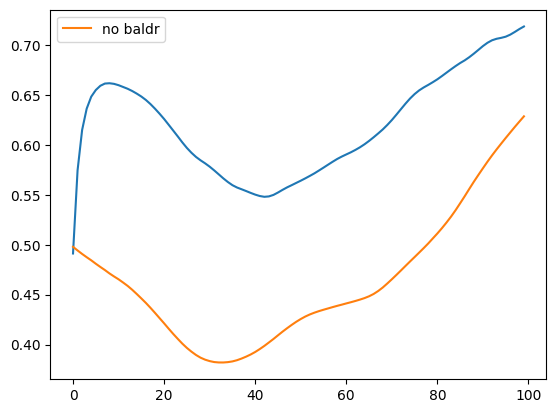

In [642]:
plt.figure()
plt.plot( strehl_list  )
plt.plot( no_baldr_strehl  , label='no baldr')
plt.legend()
plt.show()

In [636]:
no_baldr_strehl 

[array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 arr

In [ ]:
amp_input

(256, 256)

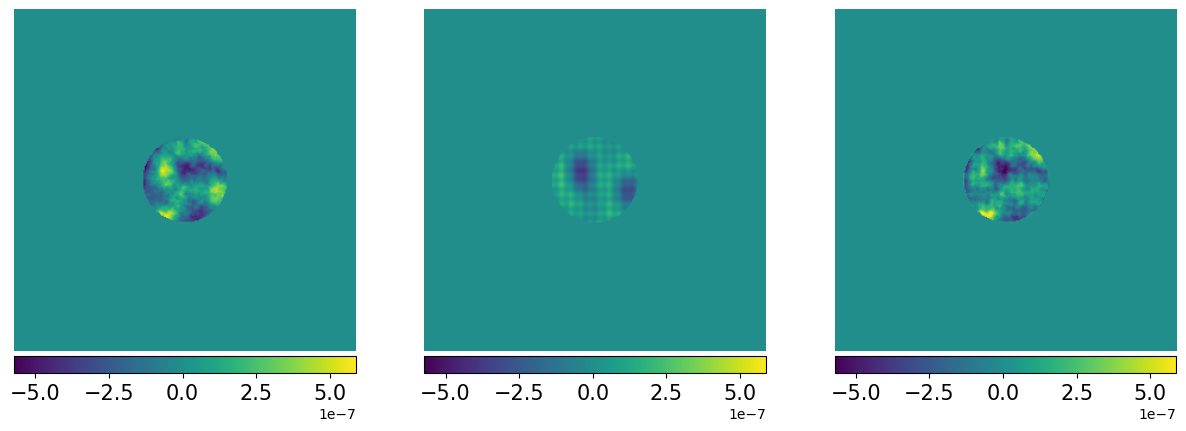

2.103122702340642e-07 1.8958190185945608e-07


In [613]:
# opd_current_dm_after = bldr.get_dm_displacement( command_vector = zwfs_ns.dm.current_cmd   , gain=zwfs_ns.dm.opd_per_cmd, \
#             sigma = zwfs_ns.grid.dm_coord.act_sigma_wavesp, X=zwfs_ns.grid.wave_coord.X, Y=zwfs_ns.grid.wave_coord.Y,\
#                 x0=zwfs_ns.grid.dm_coord.act_x0_list_wavesp, y0=zwfs_ns.grid.dm_coord.act_y0_list_wavesp )

opd_current_dm_after = opd_current_dm_after - np.mean(opd_current_dm_after[zwfs_ns.grid.pupil_mask.astype(bool)])

res = zwfs_ns.grid.pupil_mask * opd_input + zwfs_ns.grid.pupil_mask * opd_current_dm_after

im_list = [zwfs_ns.grid.pupil_mask * opd_input, zwfs_ns.grid.pupil_mask * opd_current_dm_after,res ]
vlims=[[np.min(im_list[0]), np.max(im_list[0])] for _ in range(len(im_list))]
title_list=['opd input', 'DM reconstructor', 'residual']
util.nice_heatmap_subplots( im_list = im_list , vlims=vlims ) ;plt.show()

print( np.std( opd_input[zwfs_ns.grid.pupil_mask.astype(bool)]), np.std( res[zwfs_ns.grid.pupil_mask.astype(bool)]) )


#zwfs_ns.grid.dm_coord.act_sigma_wavesp.shape


In [427]:
# Try optimize reconstructor 

basis_name =  "Zernike"
Nmodes = 100
probe_basis = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  

## in the bldr version IM requires classify regions etc, lets just do ours manually 



####### LETS BUILD IT MANUALLY 
calibration_opd_input=0 * np.zeros_like(zwfs_ns.grid.pupil_mask)

calibration_amp_input=(throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask

opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)


# zero DM 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

# get reference intensity
I0 = bldr.get_frame( 0 * opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)
I0 /= np.mean(I0)

plot = False 
rmse_dict = {}
for _ in range(5):
    poke_amp = 0.1
    m = int( np.random.uniform(low=0,high=99) )

    rmse_dict[m] = {}

    zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + poke_amp * probe_basis[m]

    ii = bldr.get_frame( calibration_opd_input,   
                calibration_amp_input  ,  
                opd_internal,  
                zwfs_ns , 
                detector=detector , 
                use_pyZelda = False).astype(float)

    ii /= np.mean(ii)

    # reconstructor 
    V = Vt.T

    for lam in np.logspace(-4,2,5):
        # Regularization / truncation knobs:
        #lam = 10             # Tikhonov (set >0 if needed)
        #smin = 1e-2 * S.max()    # optional hard gate

        rmse_dict[m][lam] = {}
    
        for smin_idx in [10,30,50,70]:
            
            
            # diagonal inverse weights for Σ (Tikhonov)
            W = S / (S*S + lam*lam)
            #W[S < smin] = 0.0
            W[smin_idx:] = 0.0
            # Reconstructor mapping pixel error -> modal coefficients (Nmodes × Npix_eff)
            R_modal = V @ (W[:,None] * U.T)    # c_hat = R_modal @ y_err_eff


            y_err = (ii - I0).reshape(-1)  # must match how A was built

            # Modal estimate (per your basis order)
            c_hat = R_modal.T @ y_err    # shape: (Nmodes,)

            residual = zwfs_ns.dm.current_cmd - c_hat

            rmse = np.mean( residual**2 )

            rmse_dict[m][lam][smin] = rmse
            if plot :
                im_list=[ii-I0 , 
                        util.get_DM_command_in_2D(zwfs_ns.dm.current_cmd), 
                        util.get_DM_command_in_2D(c_hat) , 
                        util.get_DM_command_in_2D(residual)]
                
                title_list=['signal', 
                        'DM cmd', 
                        'reco' , 
                        'residual']
                
                
                util.nice_heatmap_subplots(im_list, title_list) ;plt.show()


0.011340141296386719
0.009840250015258789
0.015861988067626953
0.01915717124938965
0.018931150436401367
0.01854109764099121


0.01118326187133789
0.012382984161376953
0.011089086532592773
0.010286092758178711
0.013950109481811523
0.018699169158935547
0.014904260635375977
0.019815921783447266
0.018886089324951172
0.01910996437072754
0.013554811477661133
0.011493682861328125
Best λ=1.000e+02, k=80, median RMSE=5.001e-01


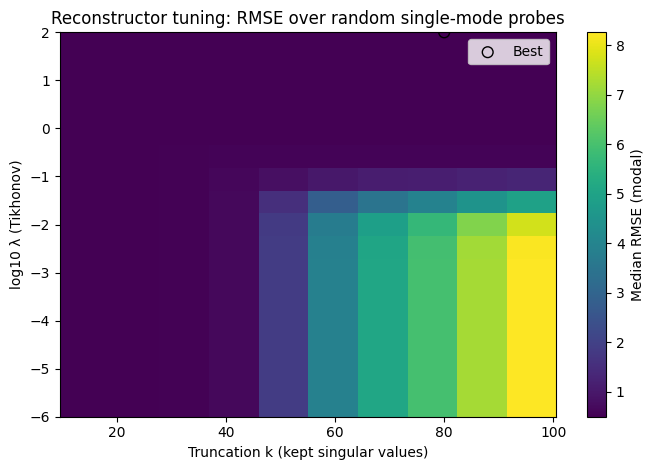

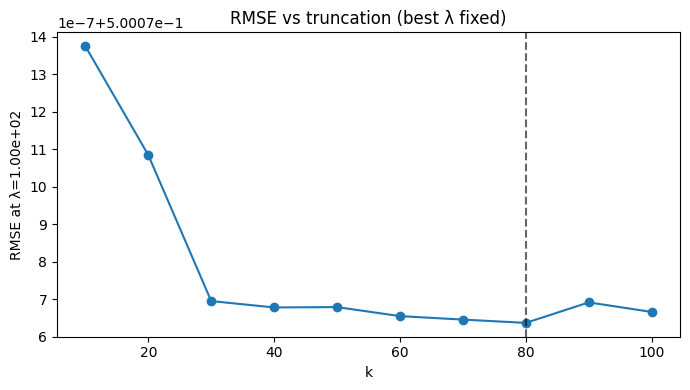

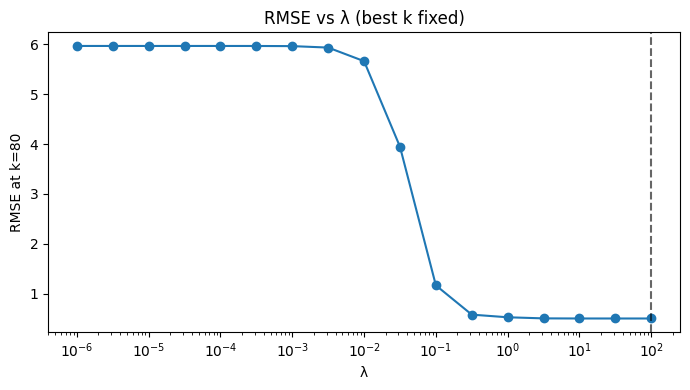

0.012583017349243164


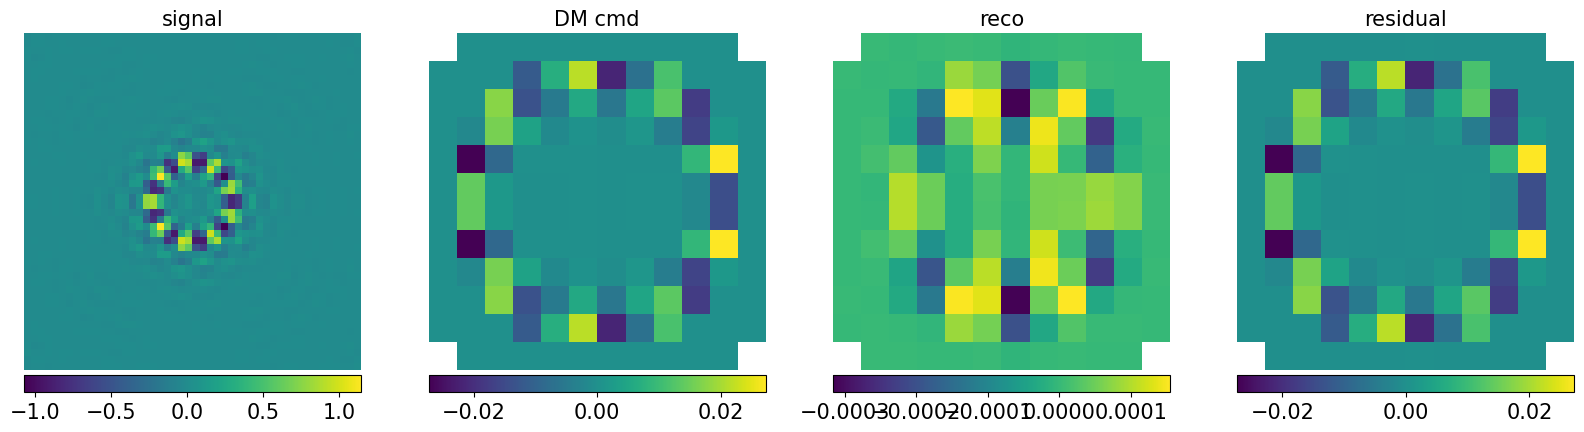

In [ ]:

basis_name =  "Zernike"
Nmodes = 100
probe_basis = DM_basis.construct_command_basis(basis=basis_name, number_of_modes=Nmodes, without_piston=True).T  


calibration_opd_input=0 * np.zeros_like(zwfs_ns.grid.pupil_mask)

calibration_amp_input=(throughput *
            (np.pi * (zwfs_ns.grid.D/2)**2) / 
            (np.pi * (zwfs_ns.grid.N/2)**2) *
            util.magnitude_to_photon_flux(magnitude=magnitude,
                                            band=waveband,
                                            wavelength=1e9*zwfs_ns.optics.wvl0))**0.5 * zwfs_ns.grid.pupil_mask

opd_internal=np.zeros_like(zwfs_ns.grid.pupil_mask)


# zero DM 
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat

# get reference intensity
I0 = bldr.get_frame( 0 * opd_input,   amp_input  ,  opd_internal,  zwfs_ns , detector=detector , use_pyZelda = False).astype(float)
I0 /= np.mean(I0)

# ---------------- Setup: basis and helpers ----------------
Nmodes = probe_basis.shape[0]          # probe_basis: (Nmodes × Nact) row-modes (as in your code)
M2C = probe_basis.T                    # (Nact × Nmodes) maps modal coeffs -> DM commands
V = Vt.T                               # from your SVD(A)

# Ensure mask matches how A was built
I0_vec = I0.reshape(-1)
mask_pixels = np.ones_like(I0_vec, dtype=bool)  # replace with your actual mask if you used one in A

# ---------------- Sweep grid ----------------
lam_vals = np.logspace(-6, 2, 17)              # Tikhonov grid
k_vals   = np.unique(np.clip([10,20,30,40,50,60,70,80,90,100], 1, len(S)))

n_probes = 12                                   # how many random probe modes to median over
poke_amp = 0.10                                 # small, linear regime

rmse_dict = {}  # rmse_dict[mode_idx][lam][k] = RMSE

for _ in range(n_probes):
    m = int(np.random.uniform(low=0, high=Nmodes))
    rmse_dict.setdefault(m, {})

    # Apply a single-mode probe on the internal source
    c_true = np.zeros(Nmodes); c_true[m] = poke_amp           # modal ground truth
    u_true = M2C @ c_true                                     # actuator vector
    zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + u_true

    # Measure frame and normalize exactly like for A/I0
    ii = bldr.get_frame(calibration_opd_input,
                        calibration_amp_input,
                        opd_internal,
                        zwfs_ns, detector=detector,
                        use_pyZelda=False).astype(float)
    ii /= ii.mean()

    y_err = (ii.reshape(-1) - I0_vec)[mask_pixels]            # pixel error (masked)

    # Grid search over (lam, k)
    for lam in lam_vals:
        rmse_dict[m].setdefault(lam, {})
        Wsig = S / (S*S + lam*lam)                            # Tikhonov
        for k in k_vals:
            Wk = Wsig.copy()
            if k < len(Wk): Wk[k:] = 0.0                      # hard truncation after k

            # Reconstructor R maps pixels->modes
            R = V @ (Wk[:, None] * U.T)                       # (Nmodes × Npix_eff)

            c_hat = R.T @ y_err    
            r_modal = zwfs_ns.dm.current_cmd - c_hat                             # (Nmodes,)
            ## this is wrong ## r_modal = (poke_amp * (np.arange(Nmodes)==m).astype(float)) - c_hat
            rmse = np.sqrt(np.mean(r_modal**2))
            rmse_dict[m][lam][int(k)] = float(rmse)

# ---------------- Aggregate across probes & pick best ----------------
# Build an array: median RMSE over probe modes for each (lam,k)
rmse_grid = np.full((len(lam_vals), len(k_vals)), np.nan)
for i, lam in enumerate(lam_vals):
    for j, k in enumerate(k_vals):
        vals = []
        for m in rmse_dict:
            if lam in rmse_dict[m] and k in rmse_dict[m][lam]:
                vals.append(rmse_dict[m][lam][k])
        if vals:
            rmse_grid[i, j] = np.median(vals)

best_idx = np.nanargmin(rmse_grid)
i_best, j_best = np.unravel_index(best_idx, rmse_grid.shape)
lam_best, k_best = lam_vals[i_best], k_vals[j_best]
print(f"Best λ={lam_best:.3e}, k={k_best:d}, median RMSE={rmse_grid[i_best,j_best]:.3e}")

# ---------------- Plots ----------------
plt.figure(figsize=(7,4.8))
im = plt.imshow(rmse_grid, origin='lower', aspect='auto',
                extent=[k_vals[0]-0.5, k_vals[-1]+0.5, np.log10(lam_vals[0]), np.log10(lam_vals[-1])])
plt.colorbar(im, label="Median RMSE (modal)")
plt.scatter([k_best], [np.log10(lam_best)], s=60, marker='o', edgecolor='k', facecolor='none', label='Best')
plt.xlabel("Truncation k (kept singular values)")
plt.ylabel("log10 λ (Tikhonov)")
plt.title("Reconstructor tuning: RMSE over random single-mode probes")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(k_vals, rmse_grid[i_best, :], marker='o')
plt.axvline(k_best, ls='--', color='k', alpha=0.6)
plt.xlabel("k")
plt.ylabel(f"RMSE at λ={lam_best:.2e}")
plt.title("RMSE vs truncation (best λ fixed)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.semilogx(lam_vals, rmse_grid[:, j_best], marker='o')
plt.axvline(lam_best, ls='--', color='k', alpha=0.6)
plt.xlabel("λ")
plt.ylabel(f"RMSE at k={k_best:d}")
plt.title("RMSE vs λ (best k fixed)")
plt.tight_layout()
plt.show()

# ---------------- Inspect a probe at the best params ----------------
# Rebuild R at best (optional quick check)
Wsig = S / (S*S + lam_best*lam_best)
Wk = Wsig.copy()
if k_best < len(Wk): Wk[k_best:] = 0.0
R_best = V @ (Wk[:, None] * U.T)

# pick one probe from rmse_dict to visualize
m_show = next(iter(rmse_dict.keys()))
# Re-run that probe
c_true = np.zeros(Nmodes); c_true[m_show] = poke_amp
u_true = M2C @ c_true
zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + u_true
ii = bldr.get_frame(calibration_opd_input, calibration_amp_input, opd_internal,
                    zwfs_ns, detector=detector, use_pyZelda=False).astype(float)
ii /= ii.mean()
y_err = (ii.reshape(-1) - I0_vec)[mask_pixels]
c_hat = R_best.T @ y_err

residual = u_true - c_hat
# quick modal diagnostic
im_list=[ii-I0 , 
        util.get_DM_command_in_2D(u_true), 
        util.get_DM_command_in_2D(c_hat) , 
        util.get_DM_command_in_2D(residual)]

title_list=['signal', 
        'DM cmd', 
        'reco' , 
        'residual']


util.nice_heatmap_subplots(im_list = im_list, title_list = title_list) ;plt.show()

In [435]:
R_best.shape
y_err.shape

(2304,)

In [208]:
# ---------------------------------------------------------
# 3) Empirical diagonal calibration D using internal source
# ---------------------------------------------------------
# Generate small test modal combinations, apply to DM, measure y, compare to truth

n_tests = min(3*Nmodes, 200)      # enough to stabilize gain estimates
amp_test = 0.03                   # small, within linear regime (DM command units)
C_true = []                       # true coefficients (Nmodes × n_tests)
C_est  = []                       # estimated coefficients via R0

rng = np.random.default_rng(2025)
for t in range(n_tests):
    # sparse-ish random modal vector (or use canonical basis if you prefer)
    c_true = np.zeros(Nmodes)
    nz = rng.choice(Nmodes, size=min(5, Nmodes), replace=False)
    c_true[nz] = amp_test * rng.standard_normal(nz.size)
    C_true.append(c_true)

    # convert to DM command & apply
    u = modal_basis.T @ c_true              # (Nact,)
    zwfs_ns.dm.current_cmd = zwfs_ns.dm.dm_flat + u

    # measure frame, normalize exactly like IM
    I = bldr.get_frame(0*zwfs_ns.grid.pupil_mask,
                       calibration_amp_input,
                       opd_internal,
                       zwfs_ns, detector=detector,
                       use_pyZelda=False).astype(float)
    I /= I.mean()

    # pixel error -> estimate
    y = (I.reshape(-1) - I0.reshape(-1))[mask_pixels]
    c_est = R0 @ y
    C_est.append(c_est)

C_true = np.stack(C_true, axis=1)  # (Nmodes × n_tests)
C_est  = np.stack(C_est,  axis=1)  # (Nmodes × n_tests)

# Solve for diagonal D that minimizes || D C_est - C_true ||_F
# Per-mode scalar: slope_k = (c_true_k · c_est_k) / (c_est_k · c_est_k)
num = np.sum(C_true * C_est, axis=1)
den = np.sum(C_est * C_est,  axis=1) + 1e-15
diag_gain = np.where(den > 0, num/den, 0.0)

# clamp pathological modes (optional)
diag_gain = np.clip(diag_gain, 0.1, 10.0)

D = np.diag(diag_gain)   # (Nmodes × Nmodes)

# Final calibrated reconstructor
R = D @ R0

print("Median modal gain:", np.median(diag_gain))
print("Min/Max modal gain:", diag_gain.min(), diag_gain.max())


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 140)

In [210]:
c_true.shape


(100,)

## See if we get the same using get frame 

In [139]:

    ii = bldr.get_pupil_intensity(
        phi=phi, 
        amp=amp, 
        theta=zwfs_ns.optics.theta, 
        phasemask_diameter = zwfs_ns.optics.mask_diam, 
        phasemask_mask = None, # generate the correct correct mask from the specified diameter
        pupil_diameter = None, # this is not used , should check if we can remove it from the signature 
        #fplane_pixels=300, 
        #pixels_across_mask=10,
        coldstop_diam=4, 
        coldstop_offset=(0.0, 0.0), 
        coldstop_mask=None, # generate the correct mask from the coldstop diam specified
        include_beta=True, 
        return_field=False, 
        return_terms=True, 
        debug=False, #<- so we see the psf and cold stop and phasemask 
        )

In [140]:
for k in ii:
    print( k , ii[k].shape )

Ic (256, 256)
psi_A (256, 256)
b_crop (256, 256)
psi_theta_crop (256, 256)
phase_disc_fp (301, 301)
cold_stop_fp (301, 301)
pix_per_wvld ()
